# Bike Sharing Demand

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%matplotlib inline
plt.rc("font", family="Malgun Gothic")

## 데이터셋 로드

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [4]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv", parse_dates=['datetime'])
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv", parse_dates=['datetime'])
sample = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv", parse_dates=['datetime'])

## 데이터셋 요약

### 데이터 Shape

In [5]:
print(train.shape, test.shape, sample.shape)

(10886, 12) (6493, 9) (6493, 2)


### 데이터 필드

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


학습 데이터에 존재하는 `casual`, `registered`, `count` 필드가 테스트 데이터에는 없다.

`sampleSubmission.csv`에 따르면 날짜 및 시간대 별로 `count`를 예측해야 한다.

### 데이터 샘플

In [8]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 결측치 확인

In [9]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

<AxesSubplot:xlabel='humidity', ylabel='count'>

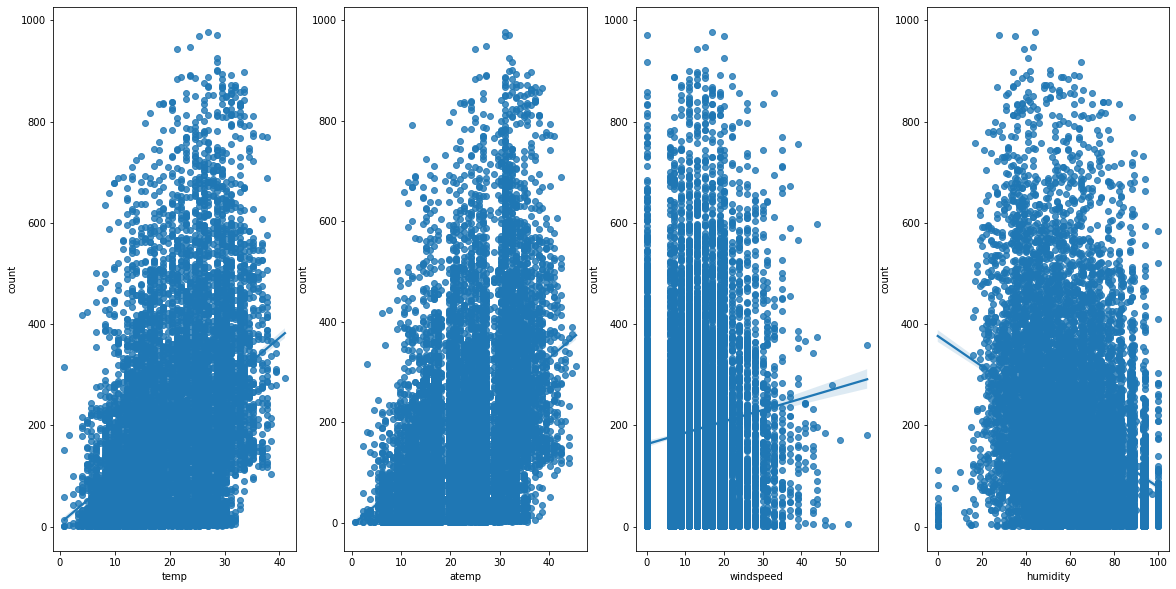

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 10)
sns.regplot(data=train, x='temp', y='count', ax=ax1)
sns.regplot(data=train, x='atemp', y='count', ax=ax2)
sns.regplot(data=train, x='windspeed', y='count', ax=ax3)
sns.regplot(data=train, x='humidity', y='count', ax=ax4)

In [12]:
print(len(train[train['windspeed'] == 0]), str(len(train[train['windspeed'] == 0])/len(train)*100)+"%")

1313 12.061363218813154%


`windspeed`의 약 12%가 0에 분포하며, 다음 구간에 분포가 비어 있다.

결측치가 0으로 기입되어 있다고 가정할 수 있다.

# EDA

## 시기별 대여량

In [13]:
def build_datetime_features(df):
    # 날짜 및 시간 피처 생성
    df['season_str'] = df['season'].map({1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"})
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['weekday'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour
    return df

In [14]:
train = build_datetime_features(train)

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_str,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,Spring,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,Spring,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,Spring,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,Spring,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,Spring,2011,1,1,5,4


<AxesSubplot:title={'center':'Rental by weather'}, xlabel='weather', ylabel='count'>

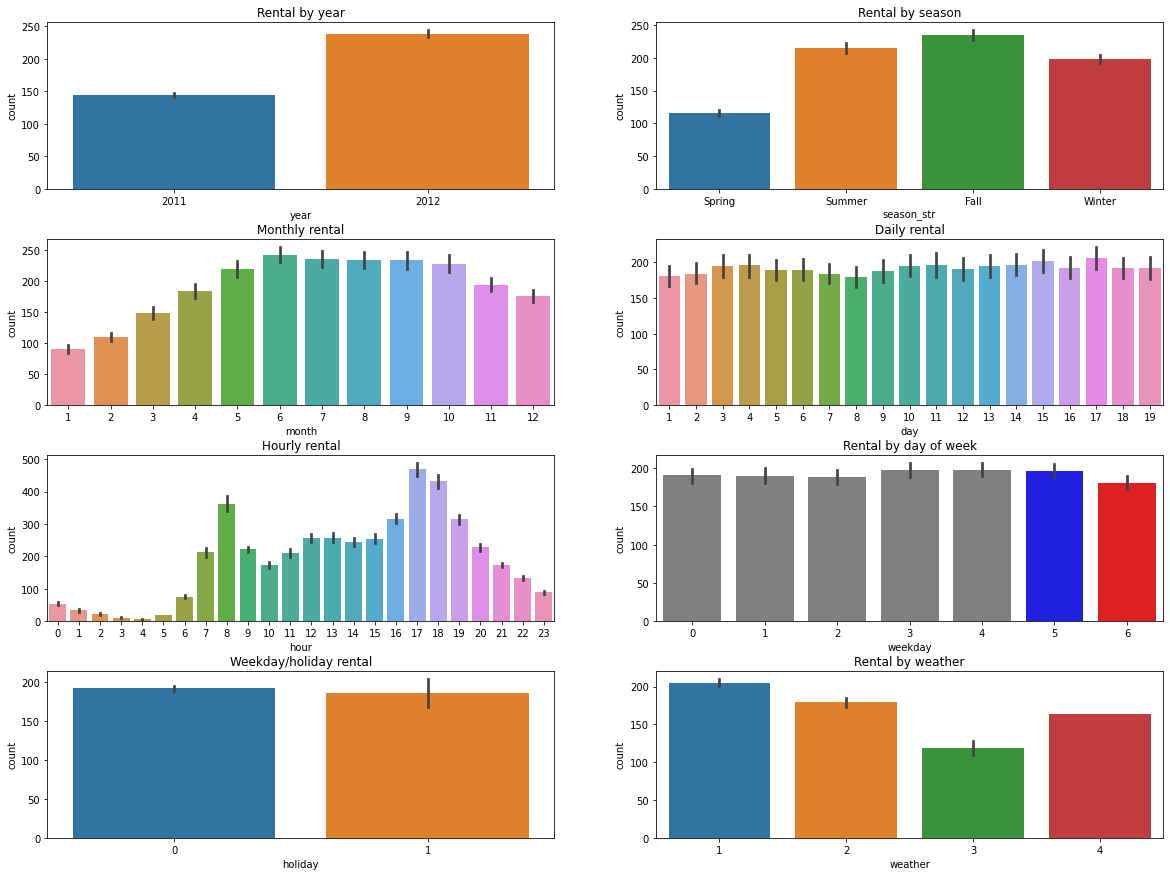

In [16]:
# Barplot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(20, 15)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax1.set(title="Rental by year")
sns.barplot(data=train, x='year', y='count', orient='v', ax=ax1)

ax2.set(title="Rental by season")
sns.barplot(data=train, x='season_str', y='count', ax=ax2)

ax3.set(title="Monthly rental")
sns.barplot(data=train, x='month', y='count', ax=ax3)

ax4.set(title="Daily rental")
sns.barplot(data=train, x='day', y='count', ax=ax4)

ax5.set(title="Hourly rental")
sns.barplot(data=train, x='hour', y='count', ax=ax5)

ax6.set(title="Rental by day of week")
sns.barplot(data=train, x='weekday', y='count', ax=ax6,
            palette=['gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'red'])

ax7.set(title="Weekday/holiday rental")
sns.barplot(data=train, x='holiday', y='count', ax=ax7)

ax8.set(title="Rental by weather")
sns.barplot(data=train, x='weather', y='count', ax=ax8)

<AxesSubplot:title={'center':'Rental by weather'}, xlabel='weather', ylabel='count'>

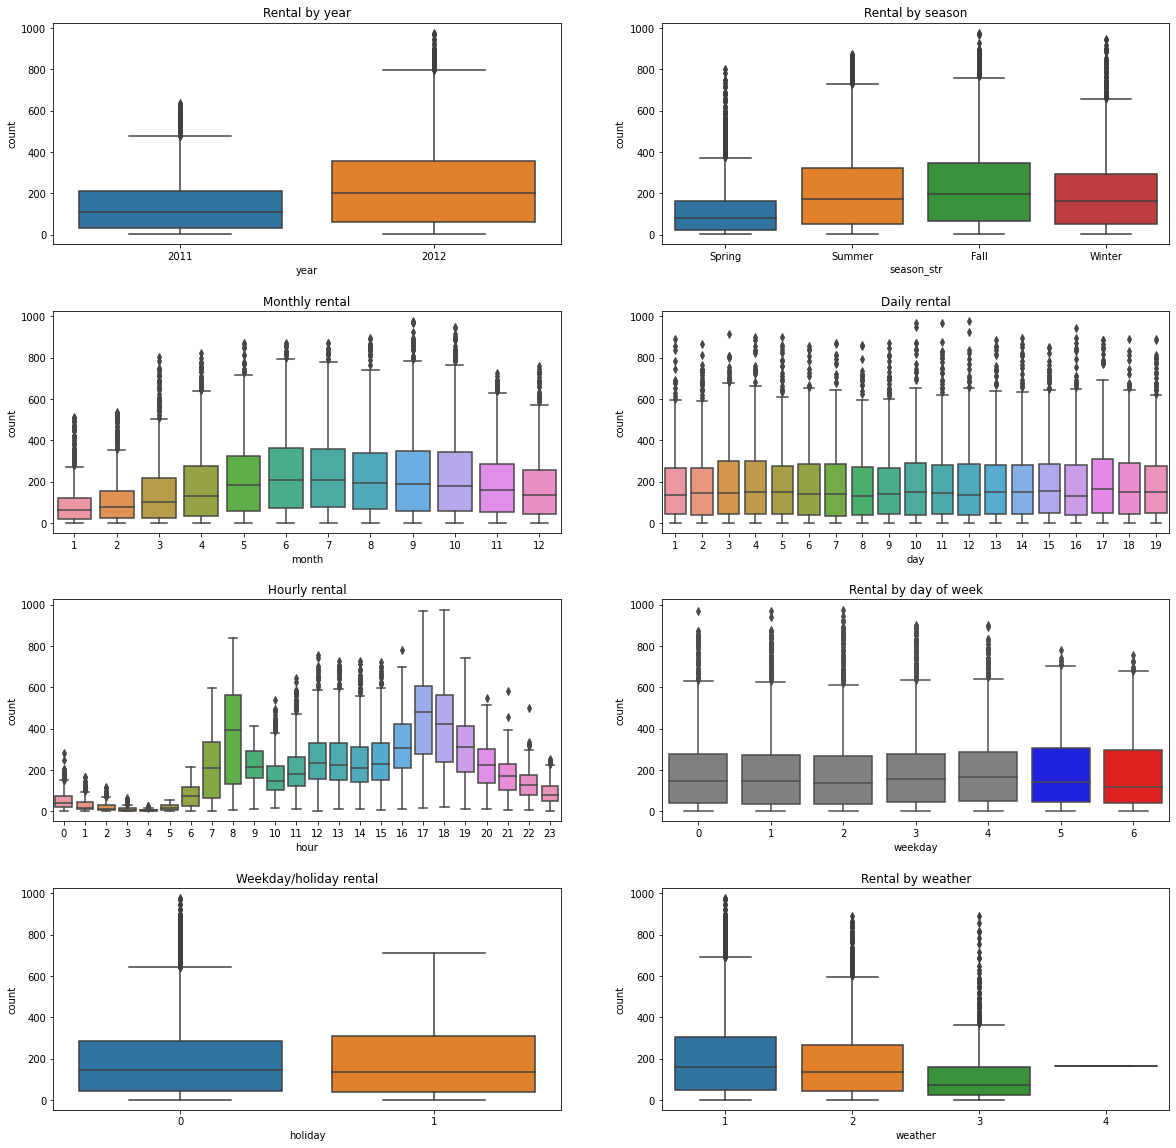

In [17]:
# Boxplot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax1.set(title="Rental by year")
sns.boxplot(data=train, x='year', y='count', ax=ax1)

ax2.set(title="Rental by season")
sns.boxplot(data=train, x='season_str', y='count', ax=ax2)

ax3.set(title="Monthly rental")
sns.boxplot(data=train, x='month', y='count', ax=ax3)

ax4.set(title="Daily rental")
sns.boxplot(data=train, x='day', y='count', ax=ax4)

ax5.set(title="Hourly rental")
sns.boxplot(data=train, x='hour', y='count', ax=ax5)

ax6.set(title="Rental by day of week")
sns.boxplot(data=train, x='weekday', y='count', ax=ax6,
            palette=['gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'red'])

ax7.set(title="Weekday/holiday rental")
sns.boxplot(data=train, x='holiday', y='count', ax=ax7)

ax8.set(title="Rental by weather")
sns.boxplot(data=train, x='weather', y='count', ax=ax8)

<AxesSubplot:xlabel='hour', ylabel='count'>

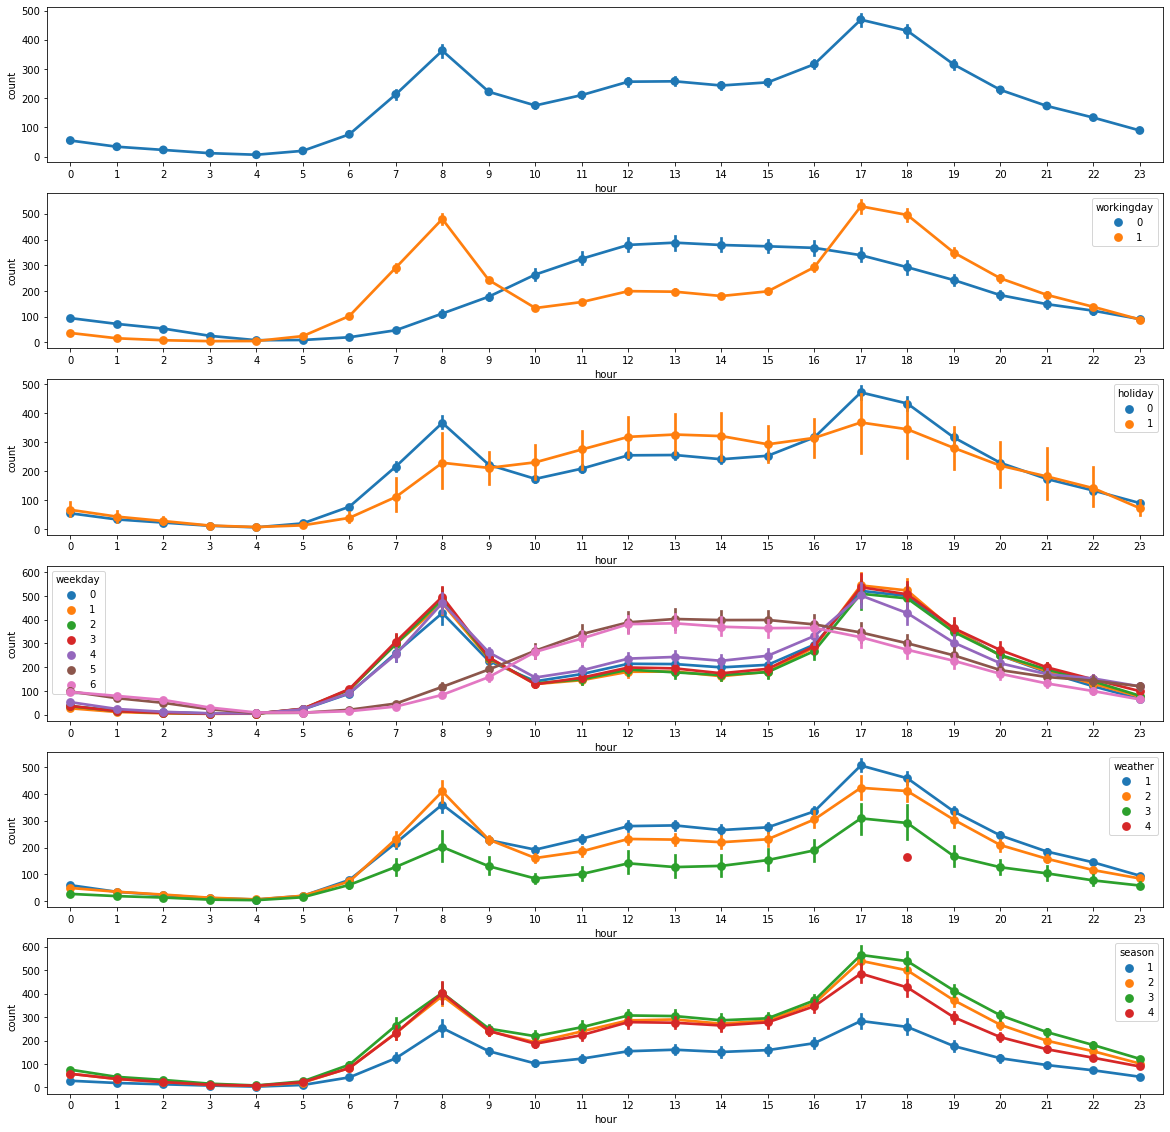

In [18]:
# 시간대별 대여량
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6)
fig.set_size_inches(20, 20)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='holiday', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weekday', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax5)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax6)

- 연도별 대여량: 2011 < 2012
- 계절별 대여량: 가을 > 여름 > 겨울 > 봄
- 월별 대여량: 6월 > 7~9월 > 10월 > 5월 > 11월 > 4월 > 12월 > 3월 > 2월 > 1월
- 시간별 대여량: 출퇴근 시간대 대여량과 편차가 큼
- 시기별 대여량: `workingday` 0과 토요일, 일요일은 비슷한 추세를 보이며, 출퇴근 시간대의 영향을 받지 않음

In [19]:
print(train[train['season'] == 1]['month'].unique())
print(train[train['season'] == 2]['month'].unique())
print(train[train['season'] == 3]['month'].unique())
print(train[train['season'] == 4]['month'].unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


`season`은 사전적 의미의 계절이 아니라 분기를 의미한다.

## 이상치 제거

In [20]:
train_normalized = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'].std())]

In [21]:
print("Shape of before normalization: ", train.shape)
print("Shape of after normalization: ", train_normalized.shape)

Shape of before normalization:  (10886, 18)
Shape of after normalization:  (10739, 18)


<AxesSubplot:title={'center':'Rental by weather'}, xlabel='weather', ylabel='count'>

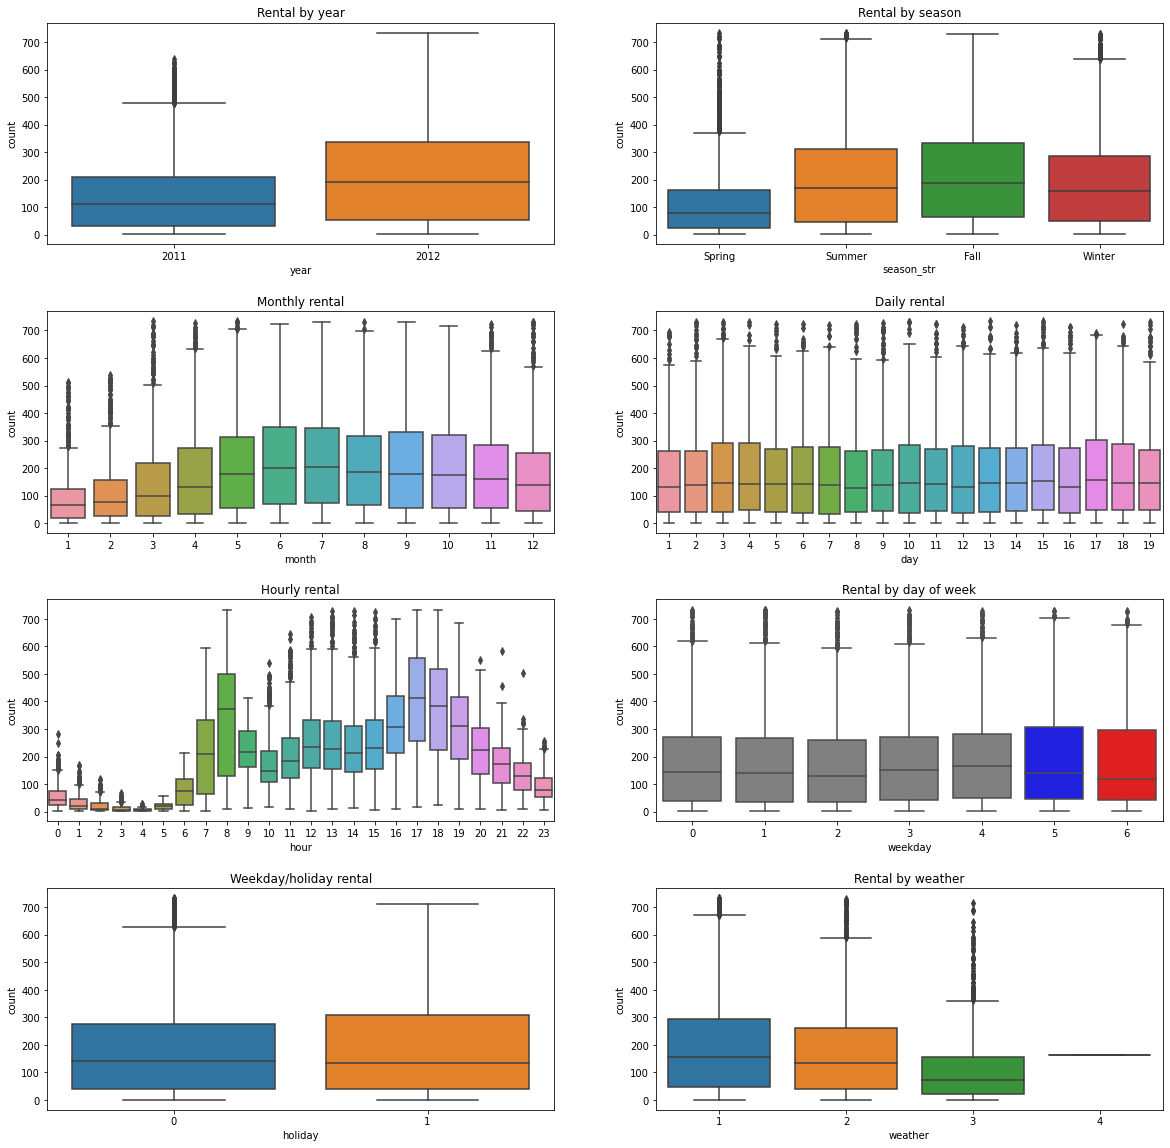

In [22]:
# Boxplot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

ax1.set(title="Rental by year")
sns.boxplot(data=train_normalized, x='year', y='count', ax=ax1)

ax2.set(title="Rental by season")
sns.boxplot(data=train_normalized, x='season_str', y='count', ax=ax2)

ax3.set(title="Monthly rental")
sns.boxplot(data=train_normalized, x='month', y='count', ax=ax3)

ax4.set(title="Daily rental")
sns.boxplot(data=train_normalized, x='day', y='count', ax=ax4)

ax5.set(title="Hourly rental")
sns.boxplot(data=train_normalized, x='hour', y='count', ax=ax5)

ax6.set(title="Rental by day of week")
sns.boxplot(data=train_normalized, x='weekday', y='count', ax=ax6,
            palette=['gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'red'])

ax7.set(title="Weekday/holiday rental")
sns.boxplot(data=train_normalized, x='holiday', y='count', ax=ax7)

ax8.set(title="Rental by weather")
sns.boxplot(data=train_normalized, x='weather', y='count', ax=ax8)

## 결측치 보정

`windspeed`의 결측치는 0으로 되어 있다. 0인 것들의 `windspeed`를 예측하여 보정한다.

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
wind0 = train.loc[train['windspeed'] == 0]
wind_not0 = train.loc[train['windspeed'] != 0]

In [25]:
print("Number of rows with 0 windspeed before prediction: ", len(wind0))

Number of rows with 0 windspeed before prediction:  1313


In [26]:
# windspeed와의 상관계수 절대값 내림차순
corr = wind_not0.corr()[['windspeed']]
corr.rename(columns={'windspeed': 'corr'}, inplace=True)
corr['corr_abs'] = corr['corr'].abs()
corr.sort_values(by='corr_abs', ascending=False)

,corr,corr_abs
windspeed,1.000000,1.000000
humidity,-0.328272,0.328272
month,-0.142505,0.142505
season,-0.138272,0.138272
hour,0.126289,0.126289
casual,0.085342,0.085342
count,0.085014,0.085014
registered,0.073669,0.073669
atemp,-0.068576,0.068576
temp,-0.038902,0.038902


In [27]:
def predict_windspeed(df):
    df_wind0 = df.loc[df['windspeed'] == 0]
    df_wind_not0 = df.loc[df['windspeed'] != 0]
    
    columns = ['humidity', 'month', 'hour', 'season', 'weather', 'atemp', 'temp']
    
    rf_model = RandomForestClassifier()
    rf_model.fit(df_wind_not0[columns], df_wind_not0['windspeed'].astype('str'))
    rf_prediction = rf_model.predict(df_wind0[columns])
    df_wind0['windspeed'] = rf_prediction
    
    result = df_wind_not0.append(df_wind0)
    result.reset_index(inplace=True)
    result.drop('index', inplace=True, axis=1)
    
    return result

In [28]:
train_before_wind = train.copy()
train = predict_windspeed(train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [29]:
print("Number of rows with 0 windspeed after prediction: ", len(train[train['windspeed'] == 0]))

Number of rows with 0 windspeed after prediction:  0


<AxesSubplot:xlabel='windspeed', ylabel='count'>

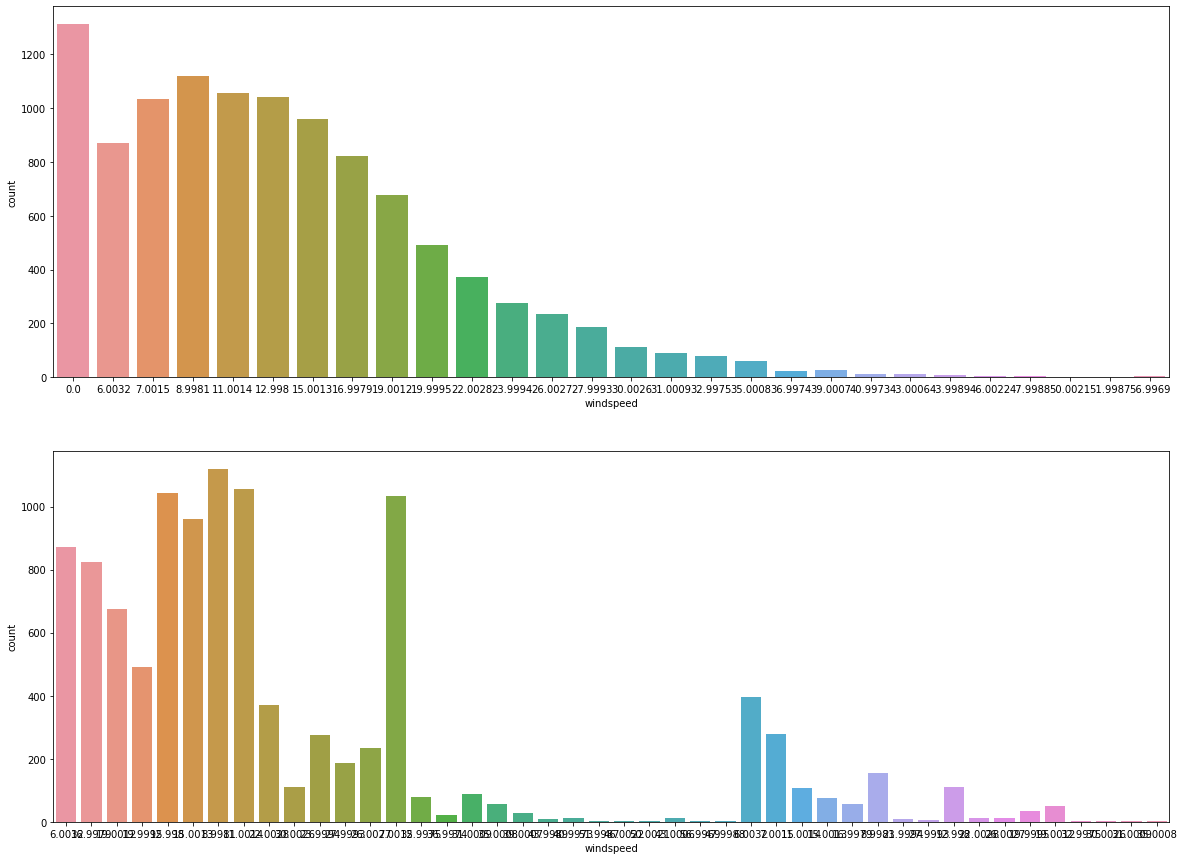

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20, 15)

sns.countplot(data=train_before_wind, x='windspeed', ax=ax1)
sns.countplot(data=train, x='windspeed', ax=ax2)

## Skewness & Kurtosis
Skewness(왜도)와 Kurtosis(첨도)를 통해 데이터 분포의 치우침을 확인하고 보정한다.

In [31]:
print("Skewness: ", train['count'].skew())
print("Kurtosis: ", train['count'].kurt())

Skewness:  1.242066211718077
Kurtosis:  1.3000929518398299


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977])),
 (169.82942673231386, 191.5741319125482, 0.9372682766213176))

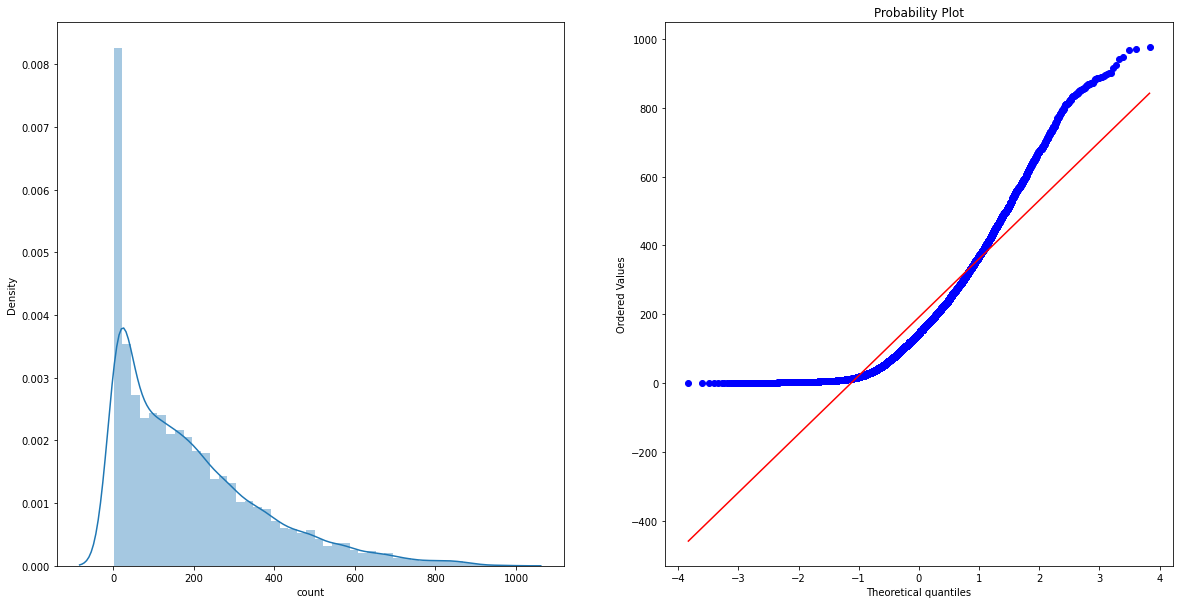

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 10)

sns.distplot(train['count'], ax=ax1)
stats.probplot(train['count'], dist="norm", fit=True, plot=ax2)

## 로그 스케일 정규화

Skewness의 쏠림이 있으므로 로그 스케일 정규화를 할 것이다.

In [33]:
train['count_log'] = np.log(train['count'])

In [34]:
print("Skewness: ", train['count_log'].skew())
print("Kurtosis: ", train['count_log'].kurt())

Skewness:  -0.9712277227866108
Kurtosis:  0.24662183416964067


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244172, 4.591363690454027, 0.9611793780126952))

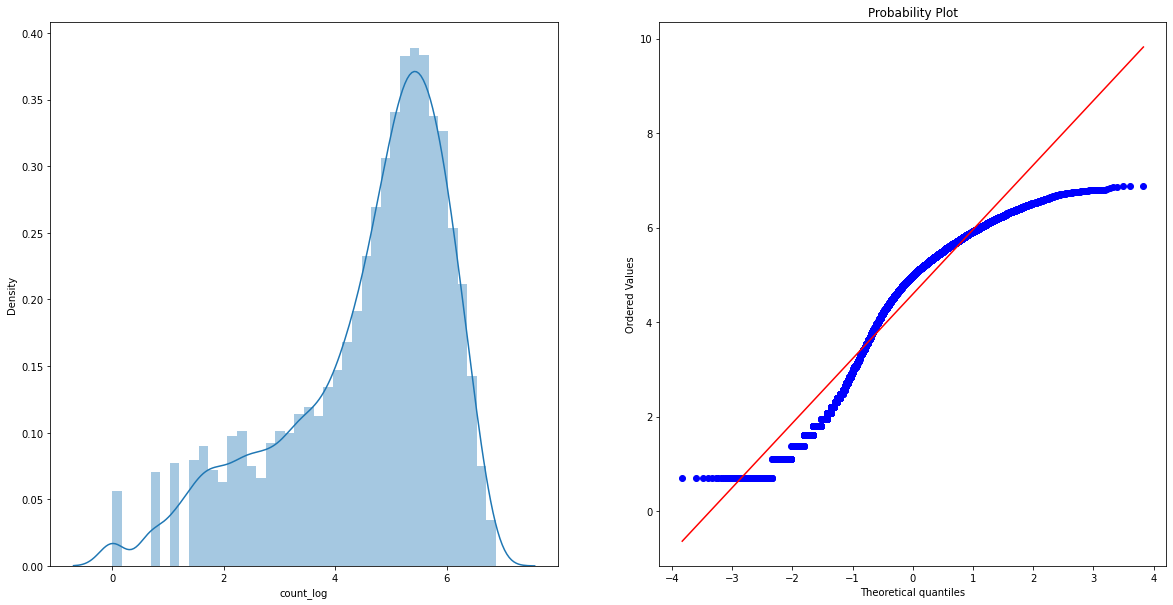

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 10)

sns.distplot(train['count_log'], ax=ax1)
stats.probplot(np.log1p(train['count']), dist="norm", fit=True, plot=ax2)

## One-hot encoding

In [36]:
print(train['weather'].unique())
print(train['season'].unique())
print(train['workingday'].unique())
print(train['holiday'].unique())

[2 1 3 4]
[1 2 3 4]
[0 1]
[0 1]


In [37]:
def one_hot_encoding(df):
    df = pd.get_dummies(df, columns=['weather'], prefix='weather')
    df = pd.get_dummies(df, columns=['season'], prefix='season')
    df = pd.get_dummies(df, columns=['workingday'], prefix='workingday')
    df = pd.get_dummies(df, columns=['holiday'], prefix='holiday')
    return df

In [38]:
train_before_encoding = train.copy()
train = one_hot_encoding(train)

In [39]:
train.columns

Index(['datetime', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'season_str', 'year', 'month', 'day', 'weekday',
       'hour', 'count_log', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'season_1', 'season_2', 'season_3', 'season_4', 'workingday_0',
       'workingday_1', 'holiday_0', 'holiday_1'],
      dtype='object')

## 상관관계 분석

<AxesSubplot:>

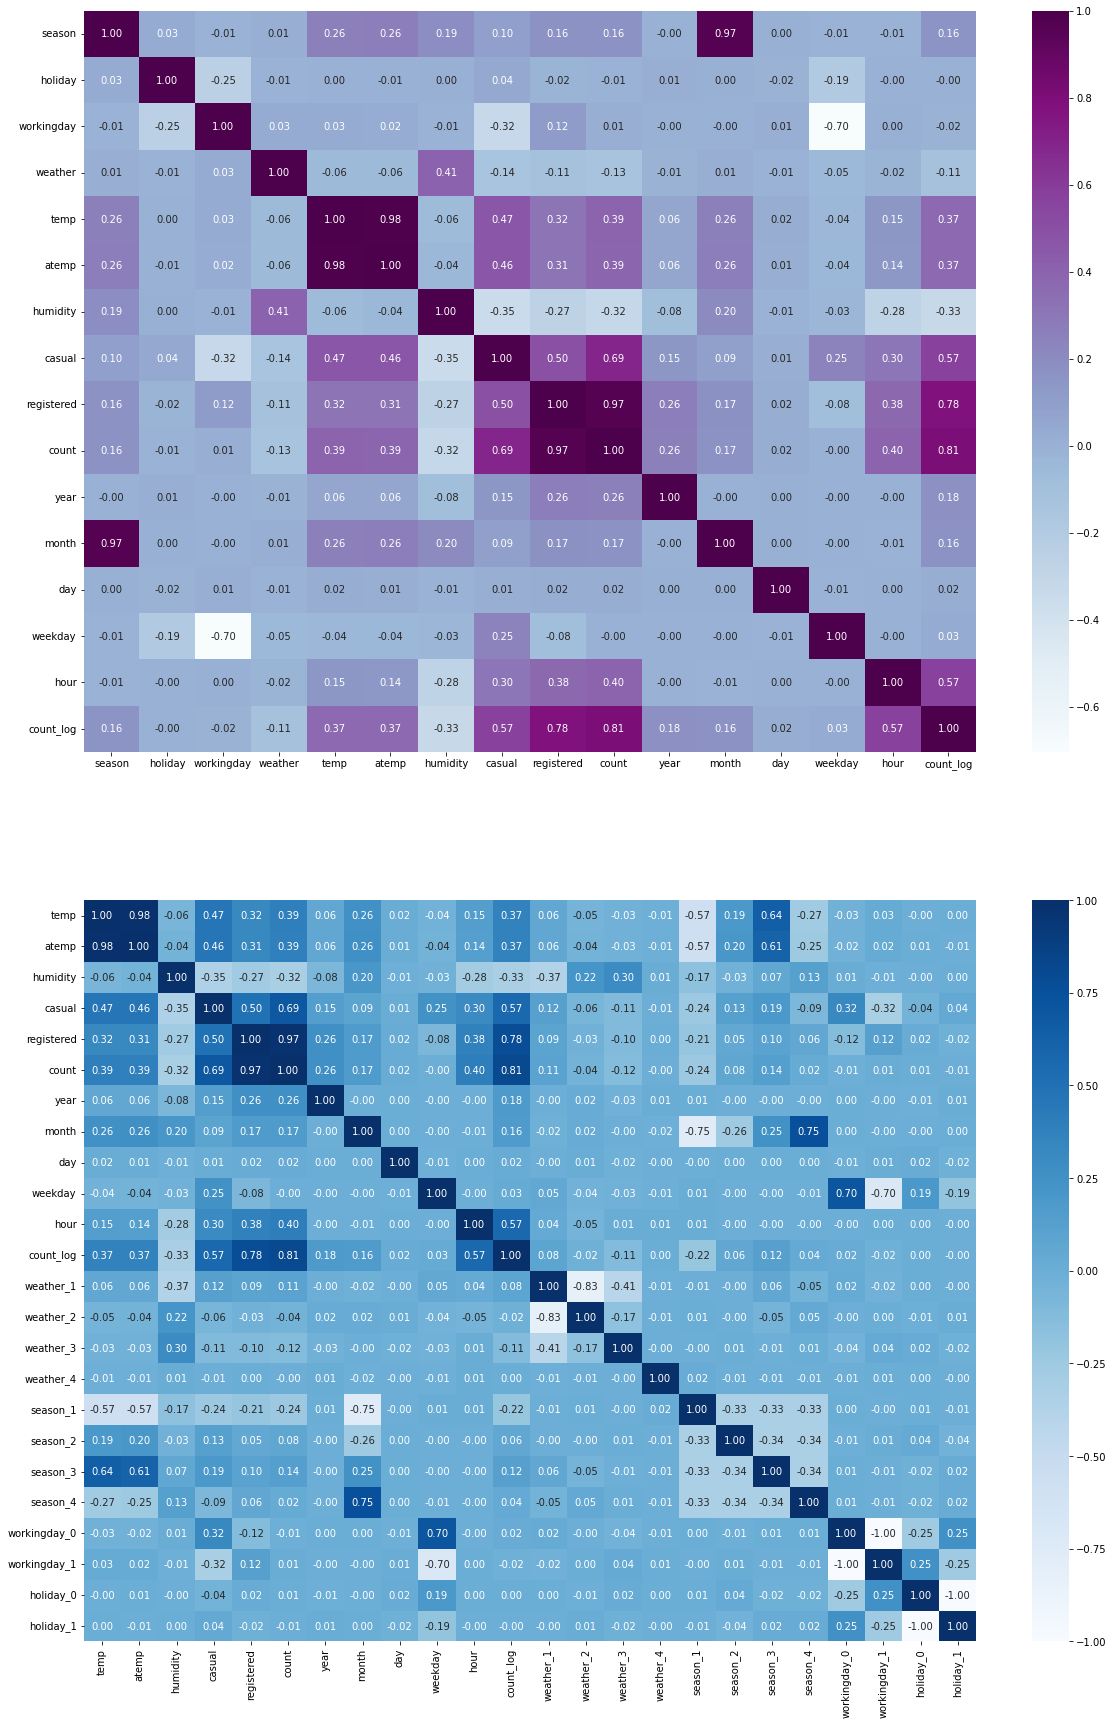

In [40]:
# Pearson 상관계수 히트맵 시각화
fix, (ax1, ax2) = plt.subplots(figsize=(20, 30), nrows=2)
sns.heatmap(train_before_encoding.corr(), annot=True, fmt=".2f", cmap="BuPu", ax=ax1)
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="Blues", ax=ax2)

In [41]:
# count와의 상관계수 절대값 내림차순
corr = train.corr()[['count']]
corr.rename(columns={'count': 'corr'}, inplace=True)
corr['corr_abs'] = corr['corr'].abs()
corr.sort_values(by='corr_abs', ascending=False)

,corr,corr_abs
count,1.000000,1.000000
registered,0.970948,0.970948
count_log,0.805773,0.805773
casual,0.690414,0.690414
hour,0.400601,0.400601
temp,0.394454,0.394454
atemp,0.389784,0.389784
humidity,-0.317371,0.317371
year,0.260403,0.260403
season_1,-0.237704,0.237704


# 모델

## 피처 엔지니어링

EDA 과정에서 Train 데이터에 행한 과정을 Test 데이터에도 적용한다.

In [42]:
test = build_datetime_features(test)
test = predict_windspeed(test)
test = one_hot_encoding(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [43]:
test.head()

,datetime,temp,atemp,humidity,windspeed,season_str,year,month,day,weekday,...,weather_3,weather_4,season_1,season_2,season_3,season_4,workingday_0,workingday_1,holiday_0,holiday_1
0,2011-01-20 00:00:00,10.66,11.365,56,26.0027,Spring,2011,1,20,3,...,0,0,1,0,0,0,0,1,1,0
1,2011-01-20 03:00:00,10.66,12.880,56,11.0014,Spring,2011,1,20,3,...,0,0,1,0,0,0,0,1,1,0
2,2011-01-20 04:00:00,10.66,12.880,56,11.0014,Spring,2011,1,20,3,...,0,0,1,0,0,0,0,1,1,0
3,2011-01-20 05:00:00,9.84,11.365,60,15.0013,Spring,2011,1,20,3,...,0,0,1,0,0,0,0,1,1,0
4,2011-01-20 06:00:00,9.02,10.605,60,15.0013,Spring,2011,1,20,3,...,0,0,1,0,0,0,0,1,1,0


## 필드 선택

1. `count`와 상관계수가 높은 필드
2. 의미가 중복되는 컬럼은 덜 분산된 필드 선택
  - ex. `workingday`와 `holiday`는 부의 상관관계가 있으나, `workingday`의 분산이 작으므로 `workingday` 선택

In [44]:
test_datetime = test['datetime']
train.drop(['datetime', 'season_str', 'holiday_0', 'holiday_1', 'atemp', 'registered', 'casual'], axis=1, inplace=True)
test.drop(['datetime', 'season_str', 'holiday_0', 'holiday_1', 'atemp'], axis=1, inplace=True)

In [45]:
print(train.columns)
print(test.columns)

Index(['temp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'weekday', 'hour', 'count_log', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'workingday_0', 'workingday_1'],
      dtype='object')
Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'weekday',
       'hour', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4', 'workingday_0', 'workingday_1'],
      dtype='object')


## Gradient boosting

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [47]:
x_train = train.drop(['count_log', 'count'], axis=1).values
target_label = train['count_log'].values
x_test = test.values

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, target_label, test_size=0.2, random_state=2000)

In [49]:
x_train

array([[14.76, 50, 16.9979, ..., 1, 0, 1],
       [33.62, 43, 19.9995, ..., 0, 1, 0],
       [31.16, 58, 19.0012, ..., 0, 0, 1],
       ...,
       [22.96, 37, 19.0012, ..., 0, 0, 1],
       [18.86, 63, 8.9981, ..., 1, 0, 1],
       [17.22, 38, 19.9995, ..., 0, 0, 1]], dtype=object)

In [50]:
gbr_model = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    random_state=42
)
gbr_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

### Validation

In [51]:
train_score = gbr_model.score(x_train, y_train)
validation_score = gbr_model.score(x_val, y_val)
print(train_score, validation_score)

0.9866447588995861 0.957037659130984


## 자전거 수요 예측

In [52]:
gbr_prediction = gbr_model.predict(x_test)
predicted_count = np.exp(gbr_prediction)

In [53]:
sample.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [54]:
submission = pd.DataFrame()
submission['datetime'] = test_datetime
submission['count'] = predicted_count

In [55]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.892524
1,2011-01-20 03:00:00,2.242351
2,2011-01-20 04:00:00,2.509201
3,2011-01-20 05:00:00,5.775774
4,2011-01-20 06:00:00,31.641682


In [56]:
submission.to_csv("bike.csv", index=False)